In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import numpy as np

from split_utils import read_fasta, Identity, compute_identity_stats
import matplotlib.pyplot as plt

# Load data

In [3]:
fasta = read_fasta("../data/build/dataset.fasta")
dataset = [int(id_) for id_, seq in fasta if 5 <= len(seq) <= 50]

# Split the data into two subsets

In [4]:
indices = np.arange(len(dataset))
np.random.shuffle(indices)
test_indices = indices[:int(len(dataset) * 0.2)]
train_indices = indices[int(len(dataset) * 0.2):]
train_ids = [dataset[i] for i in train_indices]
test_ids = [dataset[i] for i in test_indices]

# Assert independence between training and test sets

In [5]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|██████████████████████████████████████|  3587/3587 [09:10<00:00, 6.54it/s] 


Max identity: 1.0
Mean identity: 0.8545084155941263
Median identity: 0.9166666666666666
Quantiles:
- 0.01 quantile: 0.375
- 0.05 quantile: 0.46558139534883725
- 0.10 quantile: 0.5822580645161292
- 0.25 quantile: 0.8
- 0.50 quantile: 0.9166666666666666
- 0.75 quantile: 0.9615384615384616
- 0.90 quantile: 1.0
- 0.95 quantile: 1.0
- 0.99 quantile: 1.0
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
2007


Text(0, 0.5, 'Frequency')

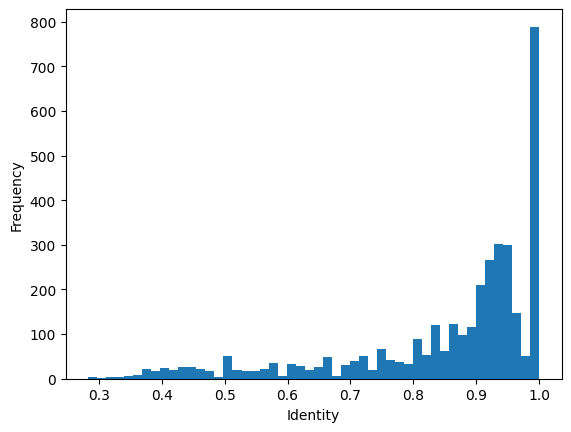

In [6]:
print(f"Max identity: {np.max(identities)}")
print(f"Mean identity: {np.mean(identities)}")
print(f"Median identity: {np.median(identities)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(identities, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(identities, bins=50)
plt.xlabel("Identity")
plt.ylabel("Frequency")